# MIE 1517 Project : Distracted Driver Detection

**Team 25:** Haitong Wang, Jianping Zhou, Jinrui Gu, Zeren Shen



Colab link: https://colab.research.google.com/drive/1HWajSoCff2qK6NHe_QNTzbWlE62u7Btr#scrollTo=lOE-0drK36z3



*   In the United States, over 3,100 people were killed and about 424,000 were injured in crashes involving a distracted driver in 2019.
*   About 1 in 5 of the people who died in crashes involving a distracted driver in 2019 were not in vehicles―they were walking, riding their bikes, or otherwise outside a vehicle.




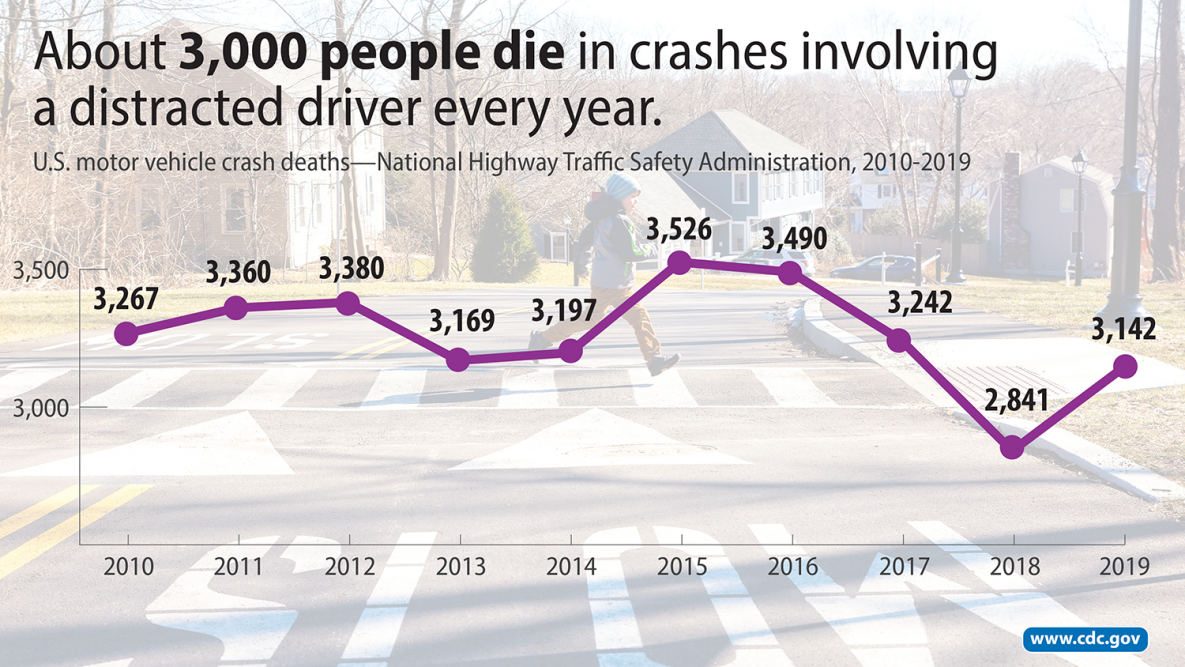

Therefore, we want to build a distracted driver detection model to detect if a driver get distracted while driving. We believe an effective model can improve driving safety in real world.

## Data Loading and Splitting

Our dataset is from a Kaggle competition: https://www.kaggle.com/c/state-farm-distracted-driver-detection/

In this dataset, there are ten different classes, including
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

There are 22424 samples in the dataset. We split it into training, validation and test set with the percentage of 80%, 10%, 10%.

There are two sets of datasets: datasets without data augmentation and datasets with data augmentation. You can specify that by calling function `get_dataloader(batch_size, augmentation)`

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import copy
import time
from distutils.dir_util import copy_tree

from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import cv2
from PIL import Image

In [ ]:
torch.manual_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/MIE\ 1517\ Project/training\ set.zip

In [ ]:
!unzip /content/gdrive/MyDrive/MIE\ 1517\ Project/Video_Frames_Balanced.zip

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

data_dir = '/content/training set/train'
splitfolders.ratio(data_dir, output="output", ratio=(0.8, 0.1, 0.1)) 

Copying files: 22424 files [00:06, 3680.68 files/s]


In [ ]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

# classes are folders in each directory with these names
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
new_data_dir = '/content/Video_Frames_Balanced'

# classes are folders in each directory with these names
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
# load and transform data using ImageFolder

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),
                                                          (0.5,0.5,0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images: ', len(test_data))

Num training images:  17934
Num validation images:  2237
Num test images:  2253


In [ ]:
new_data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5,0.5,0.5),
                                                          (0.5,0.5,0.5))])
new_data = datasets.ImageFolder(new_data_dir, transform=new_data_transform)

# print out some data stats
print('Num new data: ', len(new_data))

Num new data:  400


## Data Visualization 

In the visualization session, we introduce some samples of official data from Kaggle that we used for training, validation, and testing. The quantitative and qualitative information are shown in this session. 

Additionally, we captured the actions of our teammate driving in a car with different behaviours as the new generated data. The samples are illustrated in this session as well.

In [ ]:
# define dataloader parameters
batch_size  = 64
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
new_data_loader = torch.utils.data.DataLoader(new_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

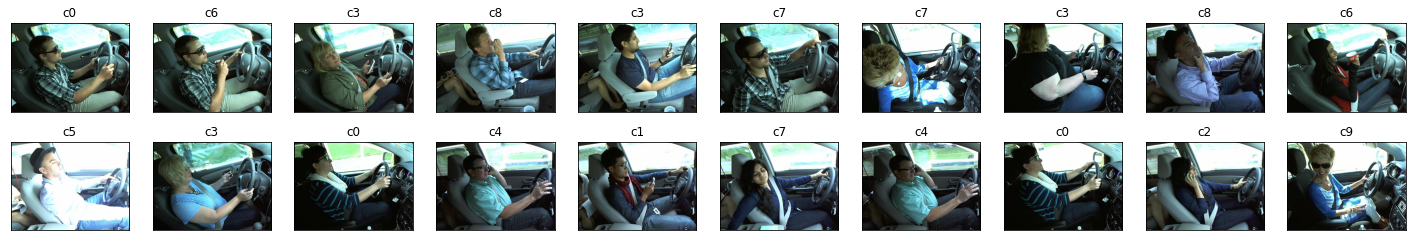

In [ ]:
# Visualize some sample data from the original dataset

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
#images = 1 / (1 + np.exp(-images))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

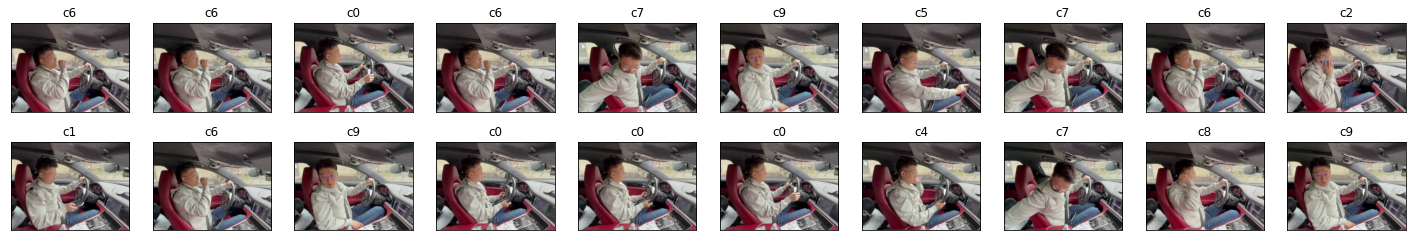

In [ ]:
# Visualize some sample data from our new dataset

# obtain one batch of training images
dataiter = iter(new_data_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
#images = 1 / (1 + np.exp(-images))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

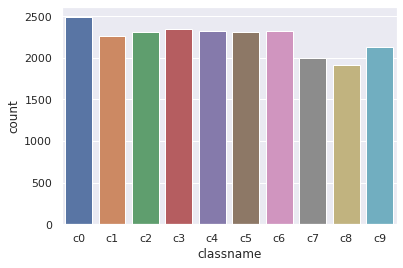

In [ ]:
# Number of images by category

import seaborn as sns

sns.set_theme(style="darkgrid")
sns.countplot(x = 'classname', data=dataset)

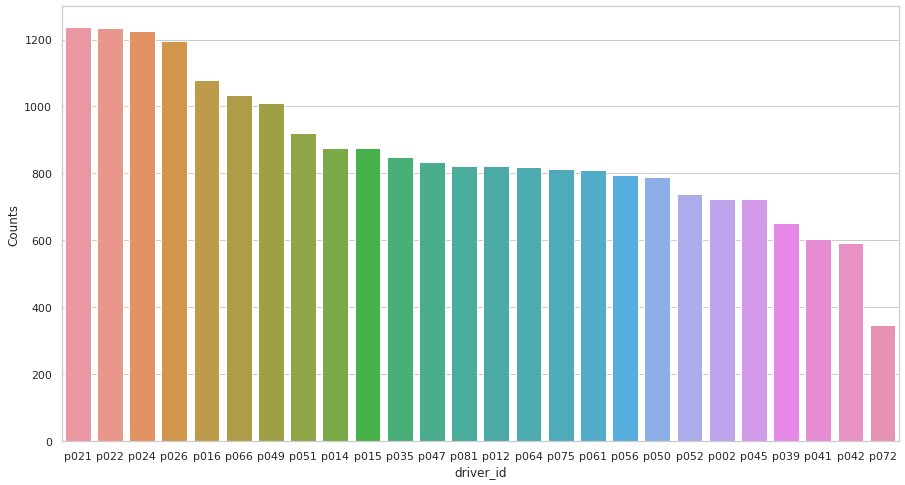

In [ ]:
# Find the frequency of images per driver

drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']

plt.figure(figsize=(15,8))
sns.barplot(x="driver_id",y="Counts", data = drivers_id)

## Data Augmentation

Data augmentation is an essential process for identifying new dataset that the model has never seen. In this session, we provide several augmentation methods including grayscale, random perspective, autoaugmentation based on IMAGENET policy. All the methods are applied to the training dataset for models training. Transformation methods are selected based on the principle shown in the link below.


ILLUSTRATION OF TRANSFORMS: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

**Original Images**

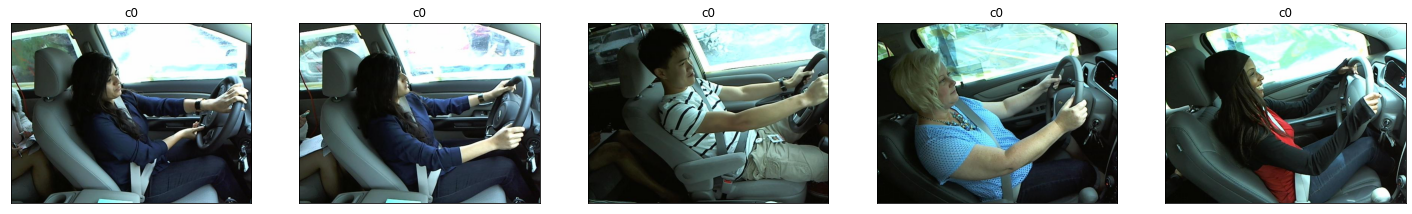

In [ ]:
# train_data_Orig

data_transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           num_workers=0, shuffle=False)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Grayscale**

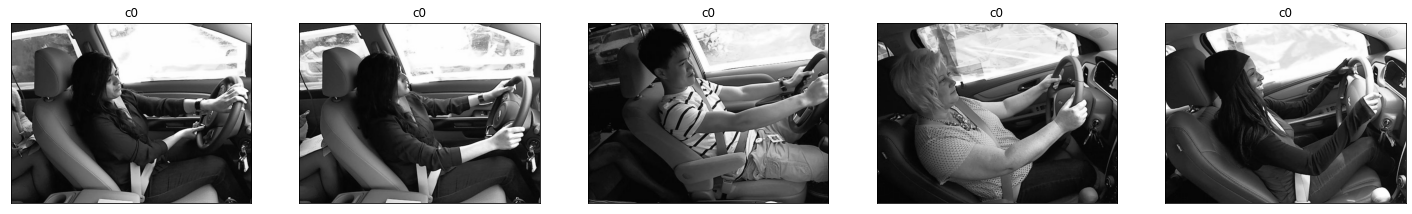

In [ ]:
# data_transform_Grayscale

data_transform_Grayscale = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                                 transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform_Grayscale)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           num_workers=0, shuffle=False)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Random Perspective**

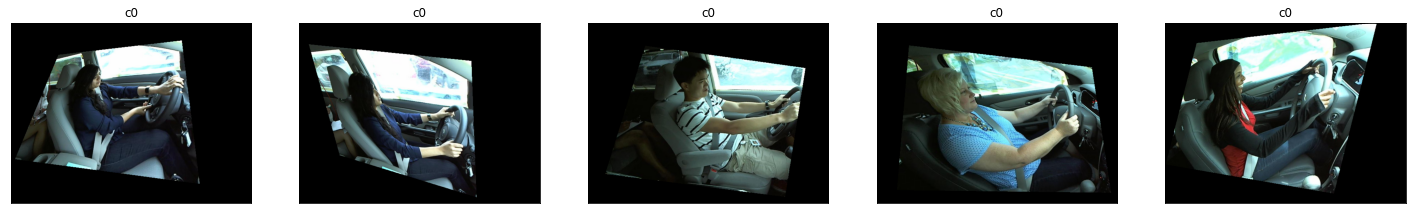

In [ ]:
# train_data_RandomPerspective

data_transform_RandomPerspective = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
                                                       transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform_RandomPerspective)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           num_workers=0, shuffle=False)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**AutoAugment**

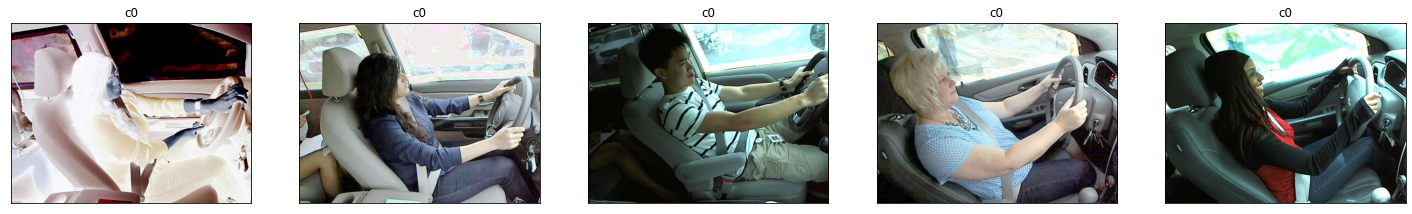

In [ ]:
# data_transform_AutoAugment

data_transform_AutoAugment = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                                                transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transform_AutoAugment)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           num_workers=0, shuffle=False)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Dataset after Augmentation**

In [ ]:
# load and transform data using ImageFolder
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                     transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
                                     transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                                     transforms.ToTensor()])

train_data_aug = datasets.ImageFolder(train_dir, transform=data_transform)
val_data_aug = datasets.ImageFolder(val_dir, transform=data_transform)
test_data_aug = datasets.ImageFolder(test_dir, transform=data_transform)


# print out some data stats
print('Num training images: ', len(train_data))

Num training images:  17934


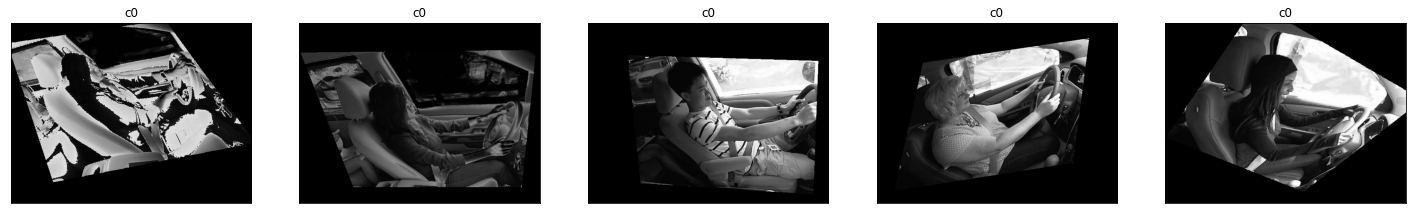

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loader['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
#images = 1 / (1 + np.exp(-images))

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
# new_data_transform = transforms.Compose([transforms.ToTensor()])
new_data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor()])
new_data_aug = datasets.ImageFolder(new_data_dir, transform=new_data_transform)

# print out some data stats
print('Num new data: ', len(new_data))

Num new data:  400


In [ ]:
def get_dataloader(batch_size, augmentation=False):
    loader = {}

    if augmentation == False:
        loader['train'] = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        loader['val'] = DataLoader(val_data, batch_size=batch_size, shuffle=True)
        loader['test'] = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        loader['new'] = DataLoader(new_data, batch_size=batch_size, shuffle=True)
    else:
        loader['train'] = DataLoader(train_data_aug, batch_size=batch_size, shuffle=True)
        loader['val'] = DataLoader(val_data_aug, batch_size=batch_size, shuffle=True)
        loader['test'] = DataLoader(test_data_aug, batch_size=batch_size, shuffle=True)
        loader['new'] = DataLoader(new_data_aug, batch_size=batch_size, shuffle=True)

    return loader

In [ ]:
loader = get_dataloader(64)

## Models

In this section, we defined several models. We use transfer learning in this task. Our models are based on pretrained **AlexNet**, **MobileNetv2**, **ResNet18**, **MobileNet V3 Small**, **MobileNet V3 Large**, **VGG16** and **GoogLeNet**.

Besides, to achieve best performance, we tried to combine results from several single models to form an ensemble model. We used three different methods to achieve final prediction: Majority Vote, Average Likelihood and Weighted Majority.

Most of our single models were trained both on training set without data augmentation and training set with data augmentation. Data augmentation plays an important role in achieving good performance on our new dataset.

The image below shows the pipeline of our project.

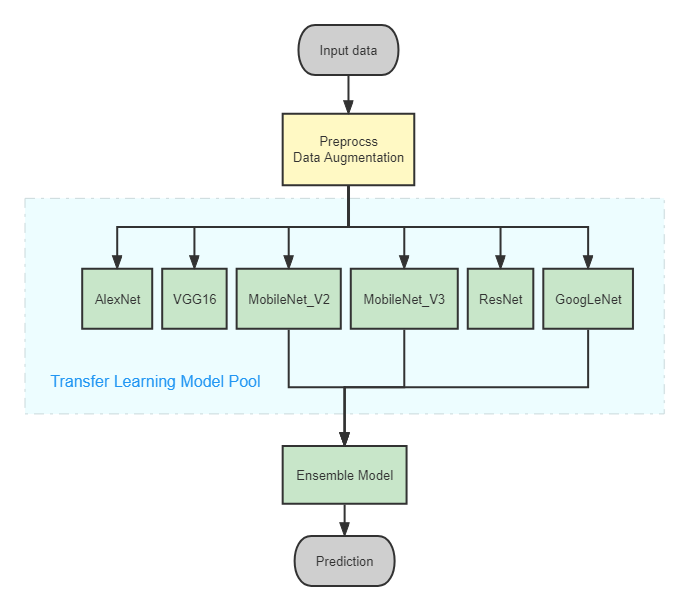

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

cuda:0
Fri Apr  1 04:14:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

The several code cells below are the functions defined for model training.

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [ ]:
def train(args, net=None):
    """
    train the neural networks
    Args:
        args, dictionary containing all the arguments used in training
            args.model(str): class name of the model
            args.augmentation(bool): whether use dataset with data augmentation
            args.num_epochs(int): number of epochs
            args.batch_size(int): batch size
            args.learning_rate(float): learning rate
            args.save_checkpoints(bool): save checkpoints
            args.save_dir_driver(str): saving directory in google drive
            args.verbose(bool): print intermediate losses and accuracy
            args.plot(bool): plot training curve and validation curve
            args.experiment_name(str): experiment name, used as folder name
        net, neural net to be trained
    Return:
        The best neural net in the training
    """

    dataloaders = get_dataloader(args.batch_size, args.augmentation)

    dataset_sizes = {}
    dataset_sizes['train'] = len(train_data)
    dataset_sizes['val'] = len(val_data)
    # dataset_sizes['test'] = len(test_data)

    save_dir = "output/" + args.experiment_name + "/"
    save_dir_driver = args.save_dir_driver + args.experiment_name + '/'

    # if path does not exist, create one
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(save_dir_driver):
        os.makedirs(save_dir_driver)

    # load net
    if net is None:
        Net = globals()[args.model]
        net = Net()

    net.to(device) # send to GPU
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=args.learning_rate)

    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0

    start_time = time.time()

    train_accs, train_losses = [], []
    val_accs, val_losses = [], []

    for epoch in range(args.num_epochs):
        print('-' * 10)
        print(f"epoch {epoch}/{args.num_epochs-1}")

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # training mode
            else:
                net.eval()  # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #track history only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_accs.append(epoch_acc.cpu().detach())
                train_losses.append(epoch_loss)
            else:
                val_accs.append(epoch_acc.cpu().detach())
                val_losses.append(epoch_loss)

            if args.verbose:
                end_str = ',' if phase == 'train' else '\n'
                print(f"{phase} Loss: {epoch_loss} Acc:{epoch_acc}", end=end_str)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc 
                best_model_wts = copy.deepcopy(net.state_dict())
            
            # save checkpoints every epoch
            if args.save_checkpoints:
                checkpoints_dir = save_dir + f"model_{net.name}_bs_{args.batch_size}_lr_{args.learning_rate}_epoch_{epoch}"
                torch.save(net.state_dict(), checkpoints_dir)
                copy_tree(save_dir, save_dir_driver)    # save to google driver
                
        # if (epoch + 1) % 10 == 0 and args.save_checkpoints:
        #     copy_tree(save_dir, save_dir_driver)

    time_elapsed = time.time() - start_time
    print()
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    # save accuracy and loss, then copy all the data to google driver
    if args.save_checkpoints:
        np.savetxt(save_dir + f"model_{net.name}_train_acc.csv", train_accs)
        np.savetxt(save_dir + f"model_{net.name}_train_loss.csv", train_losses)
        np.savetxt(save_dir + f"model_{net.name}_val_acc.csv", val_accs)
        np.savetxt(save_dir + f"model_{net.name}_val_loss.csv", val_losses)
        copy_tree(save_dir, save_dir_driver)    # save to google driver

    # plot training curve vs validation curve
    if args.plot:
        train_accs = np.array(train_accs)
        val_accs = np.array(val_accs)
        train_losses = np.array(train_losses)
        val_losses = np.array(val_losses)

        plt.plot(np.arange(args.num_epochs, step=1), train_accs, label='train')
        plt.plot(np.arange(args.num_epochs, step=1), val_accs, label='val')
        plt.title("Train vs Validation Accuracy")
        plt.legend()
        plt.show()
        plt.plot(np.arange(args.num_epochs, step=1), train_losses, label='train')
        plt.plot(np.arange(args.num_epochs, step=1), val_losses, label='val')
        plt.title("Train vs Validation Loss")
        plt.legend()
        plt.show()

    # load the best model
    net.load_state_dict(best_model_wts)

    return net

The code cells below specify the framework of the CNNs based on transfer learning as well as the training and validation accuracy for further model selections.

### AlexNet

In [ ]:
class AlexModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'alexnet'
        
        alex = models.alexnet(pretrained=True)  # load Alexnet
        for param in alex.parameters():
            param.requires_grad = False         # freeze all the network

        self.features = alex.features           # use the convolutional layers
        self.conv1 = nn.Conv2d(256, 256, 5, 2)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(256 * 2 * 4, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 2 * 4)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = x.squeeze()
        return x


In [ ]:
#alexnet without data augmentation

args = AttrDict()
args_dict = {
    'model': "AlexModel",
    'augmentation': False,
    'num_epochs': 1,
    'batch_size': 128,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': False,
    'experiment_name': "alexnet"
}
args.update(args_dict)
cnn = train(args)

----------
epoch 0/0
train Loss: 0.51137058914768 Acc:0.8418088546894168,val Loss: 0.06800645771596679 Acc:0.9803308001788109
Training complete in 4.0m 18.54066514968872s
Best val Acc: 0.9803308001788109


In [ ]:
# alexnet with data augmentation

args = AttrDict()
args_dict = {
    'model': "AlexModel",
    'augmentation': True,
    'num_epochs': 4,
    'batch_size': 128,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/",
    'verbose': True,
    'plot': False,
    'experiment_name': "alexnet"
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

----------
epoch 0/3
train Loss: 1.9733723119388153 Acc:0.2847663655626185,new Loss: 2.4716519927978515 Acc:0.1825
----------
epoch 1/3
train Loss: 1.3627228495587311 Acc:0.5323408051745289,new Loss: 2.4051555824279784 Acc:0.2125
----------
epoch 2/3
train Loss: 1.1447890906000504 Acc:0.6131928181108509,new Loss: 2.85638916015625 Acc:0.2225
----------
epoch 3/3
train Loss: 1.0343124984405345 Acc:0.6460912233745958,new Loss: 3.130733346939087 Acc:0.17

Training complete in 30.0m 13.7384672164917s
Best val Acc: 0.2225


### MobileNet V2


In [ ]:
class MobileNet_V2_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'MobileNet_V2'
        
        self.cnn = models.mobilenet_v2(pretrained=True)
        self.cnn.classifier = nn.Linear(1280, 10)

    def forward(self, x):
        return self.cnn(x)

In [ ]:
# MobileNetV2 without data augmentation

args = AttrDict()
args_dict = {
    'model': "MobileNet_V2_Model",
    'augmentation': False,
    'num_epochs': 2,
    'batch_size': 16,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/",
    'verbose': True,
    'plot': False,
    'experiment_name': "example_1"
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

----------
epoch 0/1
train Loss: 0.2824379193643383 Acc:0.9135719861715178,val Loss: 0.15847562650983815 Acc:0.9490388913723737
----------
epoch 1/1
train Loss: 0.11556010999286521 Acc:0.9659306345489015,val Loss: 0.07431859185541974 Acc:0.9789897183728208

Training complete in 13.0m 23.826667547225952s
Best val Acc: 0.9789897183728208


In [ ]:
# MobileNetV2 with data augmentation 

args = AttrDict()
args_dict = {
    'model': "MobileNet_V2_Model",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/",
    'verbose': True,
    'plot': False,
    'experiment_name': "MobileNetV2"
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

----------
epoch 0/4
train Loss: 0.9155564763011695 Acc:0.6836177093788335,new Loss: 1.3745851373672486 Acc:0.52
----------
epoch 1/4
train Loss: 0.3528331376057984 Acc:0.8884242221478755,new Loss: 0.4852812588214874 Acc:0.8025
----------
epoch 2/4
train Loss: 0.28088956327409503 Acc:0.9126798260287722,new Loss: 0.4217310339212418 Acc:0.8475
----------
epoch 3/4
train Loss: 0.22121429734835193 Acc:0.9324188691870191,new Loss: 0.3375317788124084 Acc:0.855
----------
epoch 4/4
train Loss: 0.19342311368296547 Acc:0.9443515110962418,new Loss: 0.8950838351249695 Acc:0.6375000000000001

Training complete in 54.0m 59.51597857475281s
Best val Acc: 0.855


### ResNet18


In [ ]:
class resnet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'resnet18'
        
        resnet = models.resnet18(pretrained=True)  # load Alexnet
        for param in resnet.parameters():
            param.requires_grad = False         # freeze all the network

        self.net = resnet           # use the convolutional layers
        self.cla = nn.Linear(1000,10)

    
    def forward(self, x):
        x = self.net(x)
        x = self.cla(x)
        x = x.squeeze()
        return x

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------
epoch 0/14
train Loss: 1.2445273290473349 Acc:0.6281365005018401,val Loss: 0.7924795671664662 Acc:0.7907912382655342
----------
epoch 1/14
train Loss: 0.7009443145698564 Acc:0.8072376491580239,val Loss: 0.5927694656244601 Acc:0.8341528833258829
----------
epoch 2/14
train Loss: 0.5632200390582395 Acc:0.8413070146091224,val Loss: 0.5122516174027576 Acc:0.8582923558337059
----------
epoch 3/14
train Loss: 0.4891571124401382 Acc:0.8598193375710941,val Loss: 0.4477822575709838 Acc:0.875726419311578
----------
epoch 4/14
train Loss: 0.4424708287685601 Acc:0.8730902196944351,val Loss: 0.4007117317279215 Acc:0.8824318283415289
----------
epoch 5/14
train Loss: 0.40668147548433264 Acc:0.8803390208542433,val Loss: 0.37758504600998116 Acc:0.8900312919088065
----------
epoch 6/14
train Loss: 0.384545483948914 Acc:0.8869187019069923,val Loss: 0.3628954347431207 Acc:0.8900312919088065
----------
epoch 7/14
train Loss: 0.3550757981967245 Acc:0.8929407828705253,val Loss: 0.3480097187593892

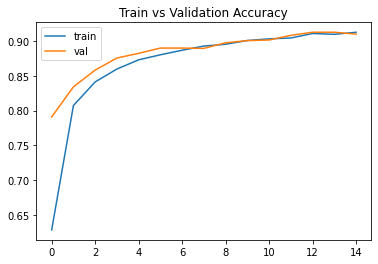

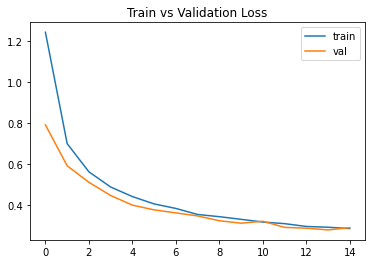

In [ ]:
# resnet18 without data augmentation

args = AttrDict()
args_dict = {
    'model': "resnet18",
    'augmentation': False,
    'num_epochs': 15,
    'batch_size': 64,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': True,
    'experiment_name': "resnet18"
}
args.update(args_dict)
cnn = train(args)

### MobileNet V3 Small


In [ ]:
class mobilenetv3small(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'mobilenet_v3_small'
        
        mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)  # load Alexnet
        for param in mobilenet_v3_small.parameters():
            param.requires_grad = False         # freeze all the network

        self.net = mobilenet_v3_small           # use the convolutional layers
        self.cla = nn.Linear(1000,10)
        #self.net.fc = nn.Linear(1024, 10)
    
    def forward(self, x):
        x = self.net(x)
        x = self.cla(x)
        x = x.squeeze()
        return x

----------
epoch 0/19
train Loss: 2.2247489947757955 Acc:0.24021411843425897,val Loss: 1.941338651991338 Acc:0.32811801519892714
----------
epoch 1/19
train Loss: 1.678468493656449 Acc:0.44764135162261626,val Loss: 1.6243926093788301 Acc:0.4202056325435852
----------
epoch 2/19
train Loss: 1.4338900141988802 Acc:0.539032006245121,val Loss: 1.382862095967115 Acc:0.6048278945015646
----------
epoch 3/19
train Loss: 1.2319800543242692 Acc:0.6290844206535073,val Loss: 1.1877474609527623 Acc:0.6016987036209209
----------
epoch 4/19
train Loss: 1.1340635483435355 Acc:0.6543994647039144,val Loss: 1.1995102026977333 Acc:0.5949932945909701
----------
epoch 5/19
train Loss: 1.0670496558909088 Acc:0.6700122672019627,val Loss: 0.983731194537934 Acc:0.707644166294144
----------
epoch 6/19
train Loss: 0.9803537178613861 Acc:0.701460912233746,val Loss: 1.0242814459755958 Acc:0.645507375949933
----------
epoch 7/19
train Loss: 0.9534260435514895 Acc:0.7033567525370804,val Loss: 0.8843433170324998 Acc:

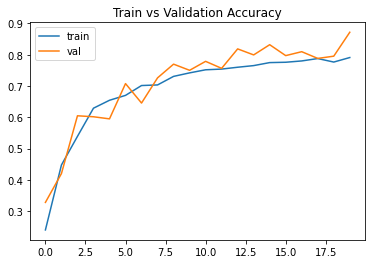

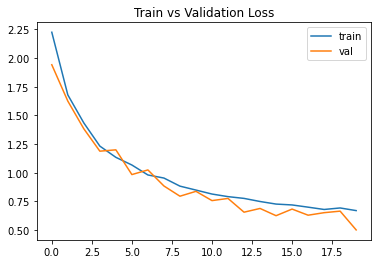

In [ ]:
# mobilenet_v3_small without data augmentation
args = AttrDict()
args_dict = {
    'model': "mobilenetv3small",
    'augmentation': False,
    'num_epochs': 20,
    'batch_size': 128,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    #'save_dir_driver': "D:/ML project/output/",
    'verbose': True,
    'plot': True,
    'experiment_name': "example_mobilenetv3_small"
}
args.update(args_dict)
cnn = train(args)

In [ ]:
# mobilenet_v3_small with data augmentation
args = AttrDict()
args_dict = {
    'model': "MobileNet_V3_Small_Model",
    'augmentation': True,
    'num_epochs': 6,
    'batch_size': 16,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/",
    'verbose': True,
    'plot': False,
    'experiment_name': "mobilev3_small_gray_aug_1"
}
args.update(args_dict)
mobile_v3_small_2 = train(args, mobile_v3_small_1)

----------
epoch 0/5
train Loss: 0.09589185750442632 Acc:0.9713951154232184,val Loss: 0.1584415599782058 Acc:0.9503799731783639
new data acc: 0.4325
----------
epoch 1/5
train Loss: 0.07121358824442633 Acc:0.9783651165384186,val Loss: 0.07621147034438532 Acc:0.9763075547608404
new data acc: 0.705
----------
epoch 2/5
train Loss: 0.06117045250857594 Acc:0.9815991970558715,val Loss: 0.1218654908661164 Acc:0.9606616003576218
new data acc: 0.48
----------
epoch 3/5
train Loss: 0.04912427008363028 Acc:0.9841083974573436,val Loss: 0.0624318724554565 Acc:0.9807778274474743
new data acc: 0.3275
----------
epoch 4/5
train Loss: 0.04616476901527842 Acc:0.9856696777071484,val Loss: 0.15299016217366307 Acc:0.9548502458649978
new data acc: 0.5325
----------
epoch 5/5
train Loss: 0.04389172055736154 Acc:0.9850563176090108,val Loss: 0.09384151352317584 Acc:0.9740724184175235
new data acc: 0.2575

Training complete in 37.0m 3.6409974098205566s
Best val Acc: 0.9807778274474743


### MobileNet V3 Large


In [ ]:
class MobileNet_V3_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'MobileNet_V3'
        
        self.cnn = models.mobilenet_v3_large(pretrained=True)
        self.cnn.classifier = nn.Sequential(nn.Dropout(0.2, inplace = True),
                                            nn.Linear(960, 10))

    def forward(self, x):
        return self.cnn(x)

In [ ]:
# mobilenet_v3_large with data augmentation

args = AttrDict()
args_dict = {
    'model': "MobileNet_V3_Model",
    'augmentation': True,
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/",
    'verbose': True,
    'plot': False,
    'experiment_name': "MobileNetV3"
}
args.update(args_dict)
cnn = train(args)

----------
epoch 0/4
train Loss: 0.48263053479030593 Acc:0.8422549347607896,new Loss: 1.2651235914230348 Acc:0.615
----------
epoch 1/4
train Loss: 0.1850519422559084 Acc:0.9443515110962418,new Loss: 0.7254015171527862 Acc:0.7775
----------
epoch 2/4
train Loss: 0.1468783027999929 Acc:0.9532731125236981,new Loss: 0.5297956988215446 Acc:0.8475
----------
epoch 3/4
train Loss: 0.11157399338245387 Acc:0.9660979145756663,new Loss: 0.8809083712100982 Acc:0.7025
----------
epoch 4/4
train Loss: 0.10289176981566922 Acc:0.9676591948254711,new Loss: 0.6732848525047302 Acc:0.7925

Training complete in 52.0m 13.206673622131348s
Best val Acc: 0.8475


### VGG16

In [ ]:
class VGGModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'vgg16'
        
        vgg = models.vgg16(pretrained=True)  # load VGGNet
        for param in vgg.parameters():
            param.requires_grad = False         # freeze all the network

        self.features = vgg.features           # use the convolutional layers
        self.conv1 = nn.Conv2d(512, 512, 5, 2)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512 * 3 * 4, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)

        
    def forward(self, x):
        x = self.features(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 512 * 3 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze()

        return x

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------
epoch 0/14
train Loss: 0.3949547854370665 Acc:0.8999107839857254,val Loss: 0.03532579520556561 Acc:0.9928475637013858
----------
epoch 1/14
train Loss: 0.013722678398528804 Acc:0.9978253596520575,val Loss: 0.023965147395930923 Acc:0.9928475637013858
----------
epoch 2/14
train Loss: 0.002549884005595014 Acc:0.9997769599643136,val Loss: 0.010193826927032003 Acc:0.9968708091193563
----------
epoch 3/14
train Loss: 0.0007795887979457533 Acc:1.0,val Loss: 0.007120655118922837 Acc:0.997764863656683
----------
epoch 4/14
train Loss: 0.0004087863068569012 Acc:1.0,val Loss: 0.006942899860953766 Acc:0.997764863656683
----------
epoch 5/14
train Loss: 0.00027887351752172736 Acc:1.0,val Loss: 0.006036702775703239 Acc:0.9973178363880197
----------
epoch 6/14
train Loss: 0.00019999881958222536 Acc:1.0,val Loss: 0.006171452898795895 Acc:0.997764863656683
----------
epoch 7/14
train Loss: 0.00015025722600410448 Acc:1.0,val Loss: 0.006053378580272457 Acc:0.997764863656683
----------
epoch 8

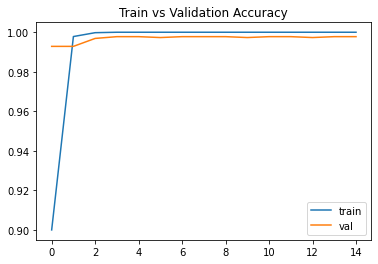

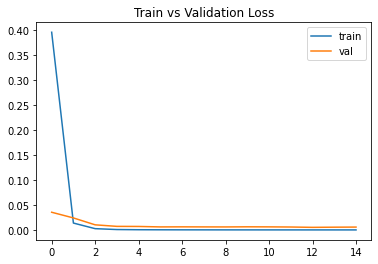

In [ ]:
# VGG16 without data augmentation

args = AttrDict()
args_dict = {
    'model': "VGGModel",
    'augmentation': False,
    'num_epochs': 15,
    'batch_size': 64,
    'learning_rate': 0.0001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': True,
    'experiment_name': "vggnet"
}
args.update(args_dict)
cnn = train(args)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------
epoch 0/3
train Loss: 1.3349896674572563 Acc:0.5522471283595406,new Loss: 1.5669475030899047 Acc:0.47750000000000004
----------
epoch 1/3
train Loss: 0.5419174789239082 Acc:0.8313817330210773,new Loss: 1.310126223564148 Acc:0.63
----------
epoch 2/3
train Loss: 0.3574675558814373 Acc:0.8900970224155236,new Loss: 1.2112566471099853 Acc:0.7000000000000001
----------
epoch 3/3
train Loss: 0.27954268328213194 Acc:0.9147429463588714,new Loss: 1.715579195022583 Acc:0.45

Training complete in 51.0m 13.519286632537842s
Best val Acc: 0.7000000000000001


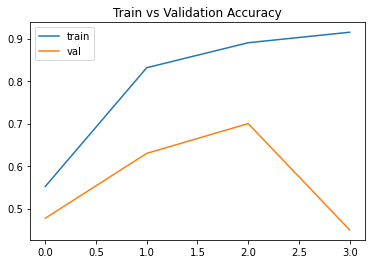

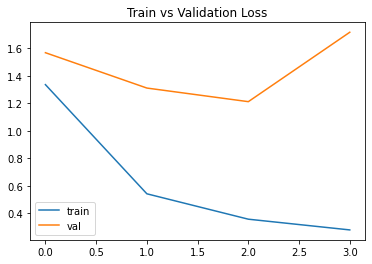

In [ ]:
# VGG16 with data augmentation

args = AttrDict()
args_dict = {
    'model': "VGGModel",
    'augmentation': True,
    'num_epochs': 4,
    'batch_size': 64,
    'learning_rate': 0.0001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/",
    'verbose': True,
    'plot': True,
    'experiment_name': "vggnet"
}
args.update(args_dict)
cnn = train(args)

### GoogLeNet

In [ ]:
class Googlenet_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'Googlenet'
        
        self.cnn = models.googlenet(pretrained=True)
        self.cnn.fc = nn.Linear(1024, 10)

    def forward(self, x):
        return self.cnn(x)

----------
epoch 0/5
train Loss: 1.5590824847258864 Acc:0.4275677484108398,new Loss: 0.8320501661300659 Acc:0.5725
----------
epoch 1/5
train Loss: 0.4937019772894927 Acc:0.8441507750641241,new Loss: 1.0017883253097535 Acc:0.68
----------
epoch 2/5
train Loss: 0.3101398009431725 Acc:0.9013047842087655,new Loss: 0.535940318107605 Acc:0.865
----------
epoch 3/5
train Loss: 0.23771552222928263 Acc:0.9272889483662318,new Loss: 0.2457151710987091 Acc:0.92
----------
epoch 4/5
train Loss: 0.205611189118367 Acc:0.9366566298650608,new Loss: 0.16417946934700012 Acc:0.9425
----------
epoch 5/5
train Loss: 0.17106144238619406 Acc:0.9493141518902644,new Loss: 1.468398333787918 Acc:0.735

Training complete in 77.0m 25.47175407409668s
Best val Acc: 0.9425


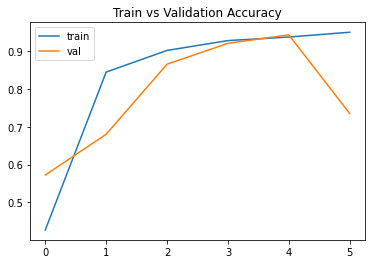

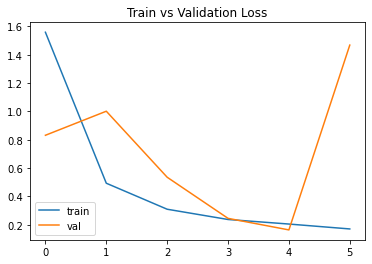

In [ ]:
# GoogleNet with data augmentation

args = AttrDict()
args_dict = {
    'model': "Googlenet_Model",
    'augmentation': True,
    'num_epochs': 6,
    'batch_size': 16,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/",
    'verbose': True,
    'plot': True,
    'experiment_name': "Googlenet_Model"
}
args.update(args_dict)
cnn = train(args)

### Ensemble Model

#### Load Single Models

In [ ]:
# load model
def load_model(args):
    """
    args:
        experiment_name(str): should be the same experiment name as used in training
        model_name(str): defined by the model class
        batch_size(int): batch size
        lr(float): learning rate
        epoch(int): the epoch you want to load
    return:
        loaded model
    """
    Model = globals()[args.model]
    model = Model()

    checkpoint_name = f"model_{model.name}_bs_{args.batch_size}_lr_{args.learning_rate}_epoch_{args.epoch}"
    experiment_dir = f"/content/gdrive/MyDrive/MIE 1517 Project/output/{args.experiment_name}/"
    model_path = experiment_dir + checkpoint_name
    model_state = torch.load(model_path)

    model.load_state_dict(model_state)

    return model

In [ ]:
# load AlexNet
args = AttrDict()
args_dict = {
    'model': "AlexModel",
    'epoch': 0,
    'batch_size': 128,
    'learning_rate': 0.001,
    'experiment_name': "alexnet"
}
args.update(args_dict)
alex = load_model(args)

In [ ]:
# load MobileNet V2
args = AttrDict()
args_dict = {
    'model': "MobileNet_V2_Model",
    'epoch': 4,
    'batch_size': 16,
    'learning_rate': 0.001,
    'experiment_name': "MobileNet_V2_0.8425"
}
args.update(args_dict)
mobilev2 = load_model(args)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
# load MobileNet V3_large
args = AttrDict()
args_dict = {
    'model': "MobileNet_V3_Model",
    'epoch': 3,
    'batch_size': 16,
    'learning_rate': 0.001,
    'experiment_name': "MobileNet_V3_large_0.8375"
}
args.update(args_dict)
mobilev3 = load_model(args)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [ ]:
# load ResNet18
res = models.resnet18(pretrained=True)

#Classifier architecture to put on top of resnet18
for param in res.parameters():
    param.requires_grad = False 
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,10)),
    ('output', nn.LogSoftmax(dim=1))
]))

res.fc = fc
res_state = torch.load("/content/gdrive/MyDrive/MIE 1517 Project/output/resnet18/model_resnet_bs_128_lr_0.001_epoch_7")
res.load_state_dict(res_state)

In [ ]:
# load VGG16
args = AttrDict()
args_dict = {
    'model': "VGGModel",
    'epoch': 1,
    'batch_size': 32,
    'learning_rate': 0.001,
    'experiment_name': "vggnet"
}
args.update(args_dict)
vgg = load_model(args)

In [ ]:
# load GoogLeNet
args = AttrDict()
args_dict = {
    'model': "Googlenet_Model",
    'epoch': 2,
    'batch_size': 16,
    'learning_rate': 0.001,
    'experiment_name': "GoogLeNet0.83"
}
args.update(args_dict)
googlenet = load_model(args)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

#### Ensemble definition
We tried 3 different methods to do ensemble model.
1. Majority vote
2. Average likelihood
3. Weighted Majority


The third method requires training.
We only use the first two methods on our new data set.

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.name = 'ensemble'
        self.num_models = len(models)
        self.models = models
        self.weights = torch.ones(self.num_models,10)


In [ ]:
def ensemble_pred(model, x):
    """
    majority vote
    """
    model.to(device)
    for net in model.models:
        net.eval()
    x = x.to(device)

    with torch.set_grad_enabled(False):    
        out = model.models[0](x)
        _, pred = torch.max(out, 1)
        pred = pred[None, :]    # add one dimension

        for i in range(1, model.num_models):
            out = model.models[i](x)
            _, new_pred = torch.max(out, 1)
            new_pred = new_pred[None, :]
            pred = torch.cat((pred, new_pred), dim=0)
    
    pred = pred.cpu().detach().numpy()
    majority = mode(pred)[0].squeeze()  # find the most frequent element in each column
    majority = torch.from_numpy(majority).to(device)    

    return majority    

In [ ]:
def ensemble_pred_2(model, x):
    """
    average likelihood
    """
    for net in model.models:
        net.eval()
        net.to(device)
    x = x.to(device)

    out_sum = torch.zeros((len(x), 10)).to(device)
    with torch.set_grad_enabled(False):    
        for i in range(model.num_models):
            out = model.models[i](x)
            if i == 2:
                out = out[:,:10]
                # prob = F.softmax(out[:,:10], dim=1)
            # else:
            #     prob = F.softmax(out, dim=1)
            out_sum += out
            # prob_sum += prob

        _, pred = torch.max(out_sum, 1)
    
    return pred

In [ ]:
def ensemble_weighted_pred(model, x):
    """
    weighted majority vote
    """
    model.to(device)
    for net in model.models:
        net.eval()
    x = x.to(device)
    data_size = len(x)
    multi_class_pred = torch.zeros((model.num_models, data_size, 10)).to(device)
    multi_class_idx = torch.zeros((model.num_models, data_size)).to(device)

    with torch.set_grad_enabled(False):
        for i in range(model.num_models):
            out = model.models[i](x)
            _, pred = torch.max(out, 1)
            multi_class_idx[i] = pred
            for single_pred, idx in zip(multi_class_pred[i], pred):
                single_pred[idx] = model.weights[i][idx]

    weight_sum = torch.sum(multi_class_pred, dim=0)
    _, final_pred = torch.max(weight_sum, 1)

    return final_pred, multi_class_idx

In [ ]:
def evaluate_model(model, loader):
    """
    Evaluate model performance on train/val/test/new set
    """
    if 'ensemble' in model.name:
        for net in model.models:
            net.eval()
            net.to(device)
    else:
        model.eval()
        model.to(device)

    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #track history only in training phase
        with torch.set_grad_enabled(False):
            if 'ensemble' in model.name:
                # preds = ensemble_pred(model, inputs)
                preds, _ = ensemble_weighted_pred(model, inputs)
            else:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
        
        running_corrects += torch.sum(preds == labels.data).item()
        num_samples += len(inputs)

    test_acc = running_corrects / num_samples 

    return test_acc

In [ ]:
def train_ensemble(model, weight_decay):
    """
    train the weights used in weighted majority method
    """
    for net in model.models:
        net.to(device)
        net.eval()
    
    last_train_acc = 0.0
    last_val_acc = 0.0

    for i in range(10):
        for inputs, labels in loader['train']:
            xs = inputs.to(device)
            ys = labels.to(device)

            # for (x, y) in zip(xs, ys):
                # x = x.unsqueeze(0)
                # print(x.shape)
            preds, indices = ensemble_weighted_pred(model, xs)
            # idx = idx.squeeze()
            for pred, y, idx in zip(preds, ys, indices.T):
                if pred != y:
                    col = idx[idx != y]
                    row = torch.where(idx != y)[0]
                    for r, c in zip(row, col):
                        model.weights[r.long()][c.long()] *= weight_decay

        # train_acc = evaluate_model(model, loader['train'])
        val_acc = evaluate_model(model, loader['val'])
        print("val acc: ", val_acc)

        if val_acc == last_val_acc:
            break
        
        # last_train_acc = train_acc
        last_val_acc = val_acc

    return model

In [ ]:
# ensemble model of the top 3 single models
ensemble3 = EnsembleModel([mobilev2, mobilev3, googlenet])

In [ ]:
trained_ensemble_3 = train_ensemble(ensemble3, 0.9)

val acc:  0.9932945909700491
val acc:  0.9937416182387125
val acc:  0.9937416182387125


In [ ]:
trained_ensemble_3.weights

tensor([[0.2824, 0.3138, 0.7290, 0.3874, 0.3874, 0.3138, 0.2288, 0.4305, 0.2288,
         0.3138],
        [0.0343, 0.2288, 0.3138, 0.5314, 0.5314, 0.9000, 0.2824, 0.3874, 0.2288,
         0.1501],
        [0.5314, 0.3874, 1.0000, 1.0000, 0.9000, 1.0000, 0.7290, 1.0000, 0.5314,
         0.2824]])

In [ ]:
weighted_ensemble_3_acc = evaluate_model(trained_ensemble_3, loader['test'])
weighted_ensemble_3_acc

0.9964491788726143

In [ ]:
ensemble_save_dir = "/content/gdrive/MyDrive/MIE 1517 Project/output/ensemble/ensemble_3_0.9"

In [ ]:
# save weights
torch.save(trained_ensemble_3.weights, ensemble_save_dir)

#### Load Ensemble Weights (weighted majority method)

In [ ]:
ensemble_save_dir = "/content/gdrive/MyDrive/MIE 1517 Project/output/ensemble/ensemble_3_0.9"

In [ ]:
ensemble_3 = EnsembleModel([alex, mobilev2, vgg])
ensemble_3.weights = torch.load(ensemble_save_dir)
ensemble_3.weights.to(device)

tensor([[0.2824, 0.3138, 0.7290, 0.3874, 0.3874, 0.3138, 0.2288, 0.4305, 0.2288,
         0.3138],
        [0.0343, 0.2288, 0.3138, 0.5314, 0.5314, 0.9000, 0.2824, 0.3874, 0.2288,
         0.1501],
        [0.5314, 0.3874, 1.0000, 1.0000, 0.9000, 1.0000, 0.7290, 1.0000, 0.5314,
         0.2824]], device='cuda:0')

##  Evaluation on test set
Is this section, we evaluate our model performance using test set in the original dataset.

### Models trained **without** data augmentation

In [ ]:
# evaluate alexnet 
alex_acc = evaluate_model(alex, loader['test'])
alex_acc

0.9831335996449179

In [ ]:
# evaluate mobilenet v2
mobilev2_acc = evaluate_model(mobilev2, loader['test'])
mobilev2_acc

0.9715934309809143

In [ ]:
# evaluate mobilenet v3_small
mobilev3_acc = evaluate_model(mobilenetv3_small, loader['test'])
mobilev3_acc

0.8686196182867288

In [ ]:
# evaluate vgg16
vgg_acc = evaluate_model(vgg, loader['test'])
vgg_acc

0.9942299156679982

In [ ]:
# evaluate resnet18
res_acc = evaluate_model(res, loader['test'])
res_acc

0.9076786506879716

In [ ]:
# evaluate ensemble model 
ensemble3_acc = evaluate_model(ensemble_3, loader['test'])
ensemble3_acc

0.9964491788726143

### Models trained **with** data augmentation

In [ ]:
mobilev2_test_acc = evaluate_model(mobilev2, loader['test'])
mobilev2_test_acc

0.9502885042166

In [ ]:
mobilev3_test_acc = evaluate_model(mobilev3, loader['test'])
mobilev3_test_acc

0.9440745672436751

In [ ]:
googlenet_test_acc = evaluate_model(googlenet, loader['test'])
googlenet_test_acc

0.9369729249889037

In [ ]:
ensemble_test_acc = evaluate_model(ensemble3, loader['test'])
ensemble_test_acc

0.9684864624944518

According to the above results, models trained without data augmentation perform better on the orginal dataset, the best model has 99.64% test accuracy.

Models trained with data augmentation have lower accuracy on testset with the best accuracy of 96.85%.

Even though test accuracy for models trained with data augmentation is a little bit lower than those without data augmentation, their performance is still good enough. In the next few sections, we'll see that models trained with data augmentation performs much better on new data set.

## New Data Generation

We recorded several videos in a car to generate our new dataset.
For each class, we recorded a short video. Then we extract frames from these 10 videos. Each single class contains 40 images, therefore there are 400 images in our new dataset.

We also recorded another video for demonstration. That video contains all ten classes.

In [ ]:
!unzip /content/gdrive/MyDrive/MIE\ 1517\ Project/Test_New_Data.zip

In [ ]:
new_data_dir = '/content/Video_Frames_Balanced'

# classes are folders in each directory with these names
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
# load and transform data using ImageFolder

data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor()])
new_data = datasets.ImageFolder(new_data_dir, transform=data_transform)

# print out some data stats
print('Num new data: ', len(new_data))

Num new data:  400


In [ ]:
def new_get_dataloader(batch_size):
    loader = {}
    loader['new'] = torch.utils.data.DataLoader(new_data, batch_size=batch_size, 
                                                shuffle=False)
    return loader

In [ ]:
dataloaders = new_get_dataloader(16)

In [ ]:
batch_size  = 16
num_workers = 0

# prepare data loaders
new_data_loader = torch.utils.data.DataLoader(new_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False)

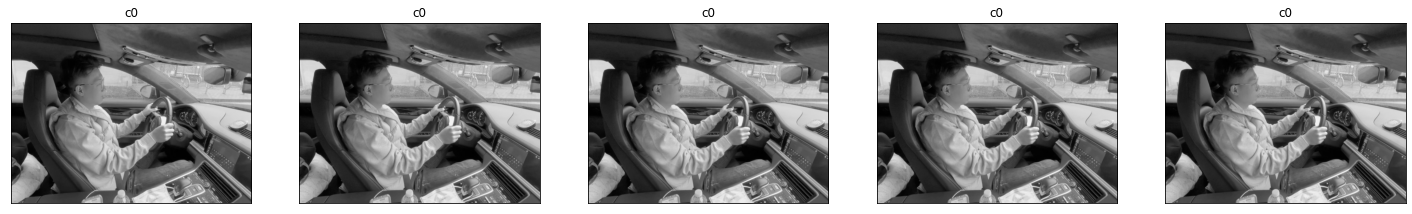

In [ ]:
# obtain one batch of training images
dataiter = iter(new_data_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Evaluation on new data set

#### Models trained **without** data augmentation

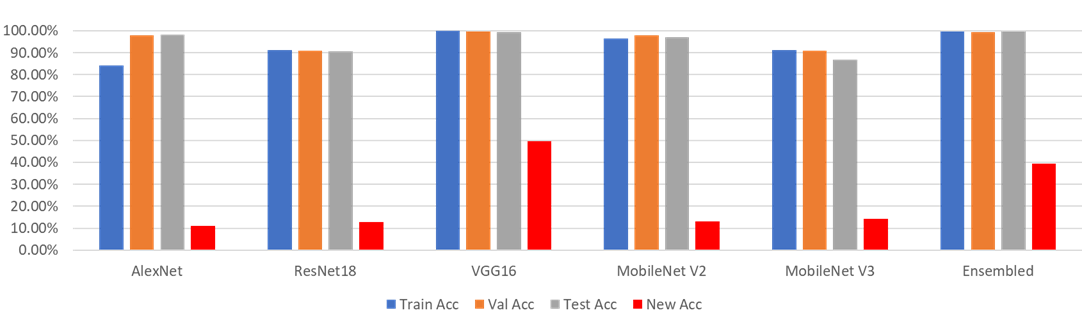

In [ ]:
# evaluate alexnet 
alex_acc = evaluate_model(alex, dataloaders['new'])
alex_acc

0.10909090909090909

In [ ]:
mobilev2_acc = evaluate_model(mobilev2, dataloaders['new'])
mobilev2_acc

0.1318181818181818

In [ ]:
# evaluate vgg16
vgg_acc = evaluate_model(vgg, dataloaders['new'])
vgg_acc

0.4954545454545455

In [ ]:
ensemble3_acc = evaluate_model(ensemble_3, dataloaders['new'])
ensemble3_acc

0.39552238805970147

In [ ]:
ensemble_save_dir = "/content/gdrive/MyDrive/MIE 1517 Project/output/ensemble/ensemble_3_0.9"
ensemble_3 = EnsembleModel([alex, mobilev2, vgg])
ensemble_3.weights = torch.load(ensemble_save_dir)
ensemble_3.weights.to(device)

ensemble3_acc = evaluate_model(ensemble_3, loader['new'])
ensemble3_acc

0.3208955223880597

#### Models trained **with** data augmentation

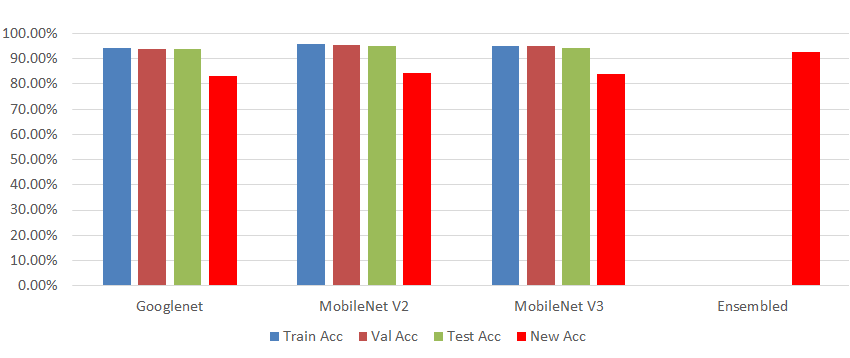

In [ ]:
mobilev2_acc = evaluate_model(mobilev2, loader['new'])
mobilev2_acc

0.8425

In [ ]:
mobilev3_acc = evaluate_model(mobilev3, loader['new'])
mobilev3_acc

0.8375

In [ ]:
googlenet_acc = evaluate_model(googlenet, loader['new'])
googlenet_acc

0.83

In [ ]:
ensemble3_acc = evaluate_model(ensemble3, loader['new'])
ensemble3_acc

0.925

We can see from the results that models trained with data augmentation perform much better than those without data augmentation.

Then we develope some functions to generate confusion matrix.


In [ ]:
def evaluate_model_analyse(model, loader):
    """
    Evaluate model performance on train/val/test/new set
    This function is useful in generating confusion matrix
    """
    if 'ensemble' in model.name:
        for net in model.models:
            net.eval()
            net.to(device)
    else:
        model.eval()
        model.to(device)

    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    total_pred = []
    total_label = []

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #track history only in training phase
        with torch.set_grad_enabled(False):
            if 'ensemble' in model.name:
                # preds = ensemble_pred(model, inputs)
                preds, _ = ensemble_weighted_pred(model, inputs)
            else:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
    
        running_corrects += torch.sum(preds == labels.data).item()
        num_samples += len(inputs)

        preds = list(preds.cpu().detach().numpy())
        true_val = list(labels.data.cpu().detach().numpy())
        total_pred += preds
        total_label += true_val

    test_acc = running_corrects / num_samples 

    return test_acc, total_pred, total_label

In [ ]:
def generate_confusion_matrix(model, loader):
    acc, pred, label = evaluate_model_analyse(model, loader)
    print("accuracy ",acc)
    pred_arr = np.array(pred)
    label_arr = np.array(label)
    conf_mat = confusion_matrix(label_arr, pred_arr)
    conf_mat_df = pd.DataFrame(conf_mat, 
                               index=['True c%d'%i for i in range(10)],
                               columns=['Pred c%d' %i for i in range(10)])
    return conf_mat_df

In [ ]:
mobilev2_conf_mat = generate_confusion_matrix(mobilev2, loader['new'])
mobilev2_conf_mat

accuracy  0.8425


Pred c0  Pred c1  Pred c2  Pred c3  Pred c4  Pred c5  Pred c6  \
True c0       40        0        0        0        0        0        0   
True c1        0        5        0        0        0        0        0   
True c2        0        0       12        0        0        0        0   
True c3        0        0        0       40        0        0        0   
True c4        0        0        0        0       40        0        0   
True c5        0        0        0        0        0       40        0   
True c6        0        0        0        0        0        0       40   
True c7        0        0        0        0        0        0        0   
True c8        0        0        0        0        0        0        0   
True c9        0        0        0        0        0        0        0   

         Pred c7  Pred c8  Pred c9  
True c0        0        0        0  
True c1        0        0       35  
True c2        0       28        0  
True c3        0        0        0  
True c4        0        0        0  
True c5        0        0        0  
True c6        0        0        0  
True c7       40        0        0  
True c8        0       40        0  
True c9        0        0       40

In [ ]:
mobilev3_conf_mat = generate_confusion_matrix(mobilev3, loader['new'])
mobilev3_conf_mat

accuracy  0.8375


Pred c0  Pred c1  Pred c2  Pred c3  Pred c4  Pred c5  Pred c6  \
True c0       26        0        0        2       12        0        0   
True c1        0       19        0        0        0        0        0   
True c2        0        0       31        0        0        0        0   
True c3        0        0        0       40        0        0        0   
True c4        0        0        0        0       40        0        0   
True c5        0        0        0        0        0       40        0   
True c6        0        0        0        0        0        0       40   
True c7        0        0        0        0        0        0        0   
True c8        0        0        0        0        0        0        0   
True c9        0        0        0        0        0        0        0   

         Pred c7  Pred c8  Pred c9  
True c0        0        0        0  
True c1        0       21        0  
True c2        0        9        0  
True c3        0        0        0  
True c4        0        0        0  
True c5        0        0        0  
True c6        0        0        0  
True c7       40        0        0  
True c8        0       40        0  
True c9       21        0       19

In [ ]:
googlenet_conf_mat = generate_confusion_matrix(googlenet, loader['new'])
googlenet_conf_mat

accuracy  0.83


Pred c0  Pred c1  Pred c2  Pred c3  Pred c4  Pred c5  Pred c6  \
True c0       22        0        0       18        0        0        0   
True c1        0       40        0        0        0        0        0   
True c2        0        0       40        0        0        0        0   
True c3        0        0        0       40        0        0        0   
True c4        0        0        0        1       39        0        0   
True c5        0        0        0        0        0       40        0   
True c6        0        0        0        0        0        0       40   
True c7        0        0        0        0        0        0        0   
True c8        4        0        4        0        0        0        1   
True c9        0        0        0        0        0        0        0   

         Pred c7  Pred c8  Pred c9  
True c0        0        0        0  
True c1        0        0        0  
True c2        0        0        0  
True c3        0        0        0  
True c4        0        0        0  
True c5        0        0        0  
True c6        0        0        0  
True c7       40        0        0  
True c8        0       31        0  
True c9       40        0        0

In [ ]:
ensemble3_conf_mat = generate_confusion_matrix(ensemble3, loader['new'])
ensemble3_conf_mat

accuracy  0.925


Pred c0  Pred c1  Pred c2  Pred c3  Pred c4  Pred c5  Pred c6  \
True c0       40        0        0        0        0        0        0   
True c1        0       40        0        0        0        0        0   
True c2        0        0       31        0        0        0        0   
True c3        0        0        0       40        0        0        0   
True c4        0        0        0        0       40        0        0   
True c5        0        0        0        0        0       40        0   
True c6        0        0        0        0        0        0       40   
True c7        0        0        0        0        0        0        0   
True c8        0        0        0        0        0        0        0   
True c9        0        0        0        0        0        0        0   

         Pred c7  Pred c8  Pred c9  
True c0        0        0        0  
True c1        0        0        0  
True c2        0        9        0  
True c3        0        0        0  
True c4        0        0        0  
True c5        0        0        0  
True c6        0        0        0  
True c7       40        0        0  
True c8        0       40        0  
True c9       21        0       19

From the confusion matrix, we can see that even though the single model performance is pretty close for mobilenet_v2, mobilenet_v3 and googlenet, they make mistakes at different classes. A simple majority vote can take advantage of all three models to have a better performance.

The ensemble model has 92.5% new data accuracy, which is higher than any single model.

#### Demonstration Video
This part contains the code for our demonstration video.
We first extract image frames from recorded video. Next, we load these images, process them with our best model, then write into a new video.

In [ ]:
img_path = "/content/gdrive/MyDrive/MIE 1517 Project/Full_Video/"

In [ ]:
# extract image from recorded video
import imutils

def get_frames():
    cap = cv2.VideoCapture('/content/Full_Video.mov')
    i = 0
    # a variable to set how many frames you want to skip
    frame_skip = 3
    # a variable to keep track of the frame to be saved
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if i > frame_skip - 1:
            frame_count += 1
            frame = imutils.resize(frame, width=640)
            cv2.imwrite('/content/gdrive/MyDrive/Uoft/Winter2022/MIE1517/Full_Video/test_'+str(frame_count)+'.jpg', frame)
            i = 0
            continue
        i += 1

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
get_frames()

In [ ]:
classes = ['c' + str(i) for i in range(10)]
full_classes = ['safe driving', 'texting right', 'phone talking right',
                'texting left', 'phone talking left', 'operating the radio',
                'drinking', 'reaching behind', 'hair and makeup',
                'talking to passenger']

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, index):
        x = self.data[index]
        return x
    
    def __len__(self):
        return len(self.data)

In [ ]:
# process the images, make predictions

img_array = []
PIL_array = []

for net in ensemble3.models:
    net.eval()
    net.to(device)

img_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                    transforms.ToTensor()])

total_pred = []
total_prob = []

# load all images, store them in two arrays
# one array for cv2 image data structure
# another array for PIL image data structure
for i in range(472):
    filename = img_path + 'test_' + str(i+1) + '.jpg'
    frame = cv2.imread(filename)
    img_array.append(frame)

    PIL_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    PIL_image = Image.fromarray(PIL_image)
    PIL_array.append(PIL_image)

# convert PIL images into tensors
imgs = torch.zeros((472,3,480,640))
for i in range(len(PIL_array)):
    img_tensor = img_transform(PIL_array[i])
    imgs[i] = img_tensor
    # print(imgs.shape)

print(imgs.shape)

new_dataset = MyDataset(imgs)
new_loader = DataLoader(new_dataset, batch_size=32,shuffle=False)

# make predictions on new data and store results
for inputs in new_loader:
    x = inputs.to(device)
    with torch.set_grad_enabled(False):
        # cnn_out = mobile_v3(x)
        pred = ensemble_pred(ensemble3, x)
        prob, _ = ensemble_pred_2(ensemble3, x)
        # out_prob = F.softmax(cnn_out, dim=1)
        # prob, pred = torch.max(out_prob, 1)

        prob = list(prob.cpu().detach().numpy())
        pred = list(pred.cpu().detach().long().numpy())
        total_prob += prob
        total_pred += pred

print(len(total_pred))
print(len(total_prob))

torch.Size([472, 3, 480, 640])
472
472


In [ ]:
# convert images (with caption) into a video

font = cv2.FONT_HERSHEY_SIMPLEX
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter('full_video_ensemble_detect_prob.mp4',
                    fourcc,
                    10,
                    (640,480))

classes_arr = np.array(full_classes)
total_pred = np.array(total_pred, dtype='int64')

frame_text = classes_arr[total_pred]

last_pred = ''
for i in range(len(img_array)):
    final_text = frame_text[i] + ": %.2f%%" % (total_prob[i] * 100)
    # add caption
    cv2.putText(img_array[i], final_text, (50,50), font, 1, (0,255,255), 2, cv2.LINE_4)
    out.write(img_array[i])

out.release()
print("over")

over


In [ ]:
# display our demonstration video
from IPython.display import HTML
from base64 import b64encode
mp4 = open('Final_Project.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Disscusion

In conclusion, the final ensebled model did a perfect job on the detection of drivers' distractive actions.
According to the workflow of the specific project, it can be shown that the application of transfer learning of classical models can significantly improve the training efficiency. Data augmentation is a crucial preproccessing procedure to enhance model performance on unseen new data.

We spent a lot of time to against the overfitting in the project. In hyper-parameter tuning process, we tried different train set size, batch size, learning rate and optimizers, but the improvement was not that obvious. We also implemented batch normalization and dropout layer in classifiers, the accuracy raised but still not good enough. We found data augmentation is the best suitable technique we could use in our case. We implemented Grayscale, RandomPerspective and AutoAugment on our training set, and the test accuracy significantly increased. We believe that it is essential to implement data augmentation method on the training set to prevent overfitting while using limited dataset in image classification problems. 

Additionaly, ensemble turns out to be a great technique in improving model performance especially when there are sufficient number of candidate models whose performance are close to each other. 

## References



1.   Krizhevsky, A. (2014). One weird trick for parallelizing convolutional neural networks. arXiv preprint arXiv:1404.5997.
2.   Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). Mobilenetv2: Inverted residuals and linear bottlenecks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4510-4520).
3. Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated residual transformations for deep neural networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1492-1500).
4. Howard, A., Sandler, M., Chu, G., Chen, L. C., Chen, B., Tan, M., ... & Adam, H. (2019). Searching for mobilenetv3. In Proceedings of the IEEE/CVF International Conference on Computer Vision (pp. 1314-1324).
5. Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.
6. Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., ... & Rabinovich, A. (2015). Going deeper with convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1-9).



## Save to HTML

In [ ]:
%%shell
jupyter nbconvert --to html /content/distracted_driver_detection.ipynb

[NbConvertApp] Converting notebook /content/distracted_driver_detection.ipynb to html
[NbConvertApp] Writing 10237205 bytes to /content/distracted_driver_detection.html
